In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data = data.sort_values('id', ascending = False)


training_set = data.iloc[0:325 - 50, : ].values  # 前(325-50=275)天的数据作为训练集,表格从0开始计数
test_set = data.iloc[325 - 50: , : ].values  # 后50天的数据作为测试集

# 归一化
sc_x = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc_y = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled_x = sc_x.fit_transform(training_set[:,2:])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
training_set_scaled_y = sc_y.fit_transform(training_set[:,1:2])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_x = sc_x.transform(test_set[:,2:])  # 利用训练集的属性对测试集进行归一化
test_set_y = sc_y.transform(test_set[:,1:2])  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前325-50=275个数据
# 利用for循环，遍历整个训练集，提取训练集中连续5天的26个降维新变量作为输入特征x_train，第6天的RON_LOSS作为标签，for循环共构建325-50-5=270组数据。

for i in range(5, len(training_set_scaled_x)):
    x_train.append(training_set_scaled_x[i - 5:i, :])
    y_train.append(training_set_scaled_y[i, :])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即270组数据；输入连续5个的26个降维新变量，预测出第6天的RON_LOSS，循环核时间展开步数为5; 每个时间步送入的特征是连续5天的26个降维新变量，有26个数据，故每个时间步输入特征个数为26
x_train = np.reshape(x_train, (x_train.shape[0], 5, 26))
# 测试集：csv表格中后50天数据
# 利用for循环，遍历整个测试集，提取测试集中连续5天的26个降维新变量作为输入特征x_train，第6天的数据作为RON_LOSS，for循环共构建50-5=45组数据。
for i in range(5, len(test_set_x)):
    x_test.append(test_set_x[i - 5 : i, :])
    y_test.append(test_set_y[i, :])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 5, 26))

model_RNN = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])

model_RNN.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
#C:\Users\Administrator\Desktop\
checkpoint_save_path = r"C:\Users\Administrator\Desktop\RNNcheckpoint\RNN_RON_LOSS.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model_RNN-----------------')
    model_RNN.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model_RNN.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model_RNN.summary()

Train on 270 samples, validate on 45 samples
Epoch 1/100
270/270 [==============================] - 3s 11ms/sample - loss: 1.0966 - val_loss: 0.0743
Epoch 2/100
270/270 [==============================] - 0s 233us/sample - loss: 0.7223 - val_loss: 0.1253
Epoch 3/100
270/270 [==============================] - 0s 222us/sample - loss: 0.4265 - val_loss: 0.2684
Epoch 4/100
270/270 [==============================] - 0s 208us/sample - loss: 0.4812 - val_loss: 0.1140
Epoch 5/100
270/270 [==============================] - 0s 226us/sample - loss: 0.3383 - val_loss: 0.0757
Epoch 6/100
270/270 [==============================] - 0s 844us/sample - loss: 0.2490 - val_loss: 0.0302
Epoch 7/100
270/270 [==============================] - 0s 228us/sample - loss: 0.2129 - val_loss: 0.0369
Epoch 8/100
270/270 [==============================] - 0s 939us/sample - loss: 0.2240 - val_loss: 0.0237
Epoch 9/100
270/270 [==============================] - 0s 786us/sample - loss: 0.1949 - val_loss: 0.0234
Epoch 10/10

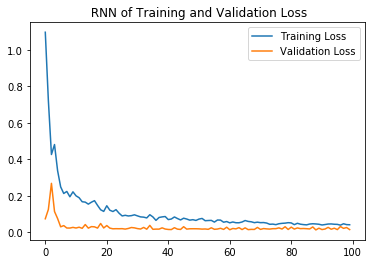

In [2]:
file = open('C:/Users/Administrator/Desktop/RNN_RON_LOSS_weights.txt', 'w' )  # 参数提取
for v in model_RNN.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title(' RNN of Training and Validation Loss')
plt.legend()
#plt.show()
plt.savefig(r"C:\Users\Administrator\Desktop\RNN_Loss.jpg")


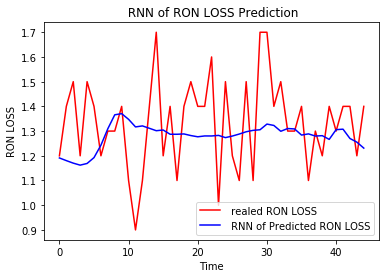

In [3]:
 #####看图######
################## predict ######################
# 测试集输入模型进行预测
predicted_RON_LOSS = model_RNN.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_RON_LOSS = sc_y.inverse_transform(y_test)
# 画出真实数据和预测数据的对比曲线
plt.plot(real_RON_LOSS, color='red', label=' realed RON LOSS')
plt.plot(predicted_RON_LOSS, color='blue', label=' RNN of Predicted RON LOSS')
plt.title(' RNN of RON LOSS Prediction')
plt.xlabel('Time')
plt.ylabel('RON LOSS')
plt.legend()
#plt.show()
plt.savefig(r"C:\Users\Administrator\Desktop\RNN_predict.jpg")


In [4]:
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_RON_LOSS, real_RON_LOSS)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_RON_LOSS, real_RON_LOSS))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_RON_LOSS, real_RON_LOSS)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)


均方误差: 0.038790
均方根误差: 0.196952
平均绝对误差: 0.159756


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data = data.sort_values('id', ascending = False)


training_set = data.iloc[0:325 - 50, : ].values  #  前(325-50=275)天的数据作为训练集,表格从0开始计数
test_set = data.iloc[325 - 50: , : ].values  # 后50天的数据作为测试集

# 归一化
sc_x = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc_y = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled_x = sc_x.fit_transform(training_set[:,2:])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
training_set_scaled_y = sc_y.fit_transform(training_set[:,1:2])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_x = sc_x.transform(test_set[:,2:])  # 利用训练集的属性对测试集进行归一化
test_set_y = sc_y.transform(test_set[:,1:2])  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []


# 测试集：csv表格中前325-50=275个数据
# 利用for循环，遍历整个训练集，提取训练集中连续5天的26个降维新变量作为输入特征x_train，第6天的RON_LOSS作为标签，for循环共构建325-50-5=270组数据。

for i in range(5, len(training_set_scaled_x)):
    x_train.append(training_set_scaled_x[i - 5:i, :])
    y_train.append(training_set_scaled_y[i, :])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即270组数据；输入连续5个的26个降维新变量，预测出第6天的RON_LOSS，循环核时间展开步数为5; 每个时间步送入的特征是连续5天的26个降维新变量，有26个数据，故每个时间步输入特征个数为26
x_train = np.reshape(x_train, (x_train.shape[0], 5, 26))
# 测试集：csv表格中后50天数据
# 利用for循环，遍历整个测试集，提取测试集中连续5天的26个降维新变量作为输入特征x_train，第6天的数据作为RON_LOSS，for循环共构建50-5=45组数据。
for i in range(5, len(test_set_x)):
    x_test.append(test_set_x[i - 5 : i, :])
    y_test.append(test_set_y[i, :])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 5, 26))


model_LSTM = tf.keras.Sequential([
    LSTM(80, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
#C:\Users\Administrator\Desktop\
checkpoint_save_path = r"C:\Users\Administrator\Desktop\LSTMcheckpoint\LSTM_RON_LOSS.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model_LSTM-----------------')
    model_LSTM.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model_LSTM.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model_LSTM.summary()


Train on 270 samples, validate on 45 samples
Epoch 1/100
270/270 [==============================] - 6s 22ms/sample - loss: 0.2227 - val_loss: 0.0287
Epoch 2/100
270/270 [==============================] - 0s 1ms/sample - loss: 0.0793 - val_loss: 0.0244
Epoch 3/100
270/270 [==============================] - 0s 322us/sample - loss: 0.0386 - val_loss: 0.0373
Epoch 4/100
270/270 [==============================] - 0s 300us/sample - loss: 0.0470 - val_loss: 0.0298
Epoch 5/100
270/270 [==============================] - 0s 941us/sample - loss: 0.0323 - val_loss: 0.0146
Epoch 6/100
270/270 [==============================] - 0s 315us/sample - loss: 0.0310 - val_loss: 0.0156
Epoch 7/100
270/270 [==============================] - 0s 330us/sample - loss: 0.0280 - val_loss: 0.0157
Epoch 8/100
270/270 [==============================] - 0s 382us/sample - loss: 0.0266 - val_loss: 0.0194
Epoch 9/100
270/270 [==============================] - 0s 385us/sample - loss: 0.0260 - val_loss: 0.0168
Epoch 10/100


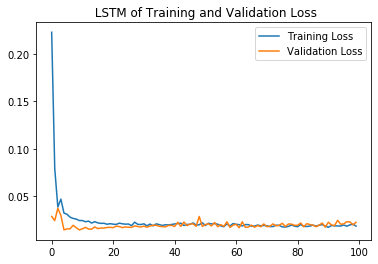

In [6]:
file = open('C:/Users/Administrator/Desktop/LSTM_RON_LOSS_weights.txt', 'w' )  # 参数提取
for v in model_LSTM.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title(' LSTM of Training and Validation Loss')
plt.legend()
#plt.show()
plt.savefig(r"C:\Users\Administrator\Desktop\LSTM_Loss.jpg")

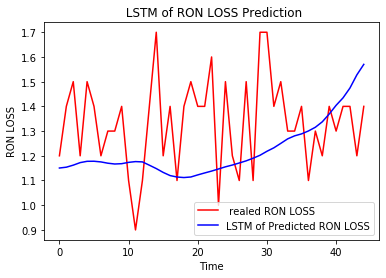

In [7]:
################## predict ######################
# 测试集输入模型进行预测
predicted_RON_LOSS = model_LSTM.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_RON_LOSS = sc_y.inverse_transform(y_test)
# 画出真实数据和预测数据的对比曲线
plt.plot(real_RON_LOSS, color='red', label=' realed RON LOSS')
plt.plot(predicted_RON_LOSS, color='blue', label='LSTM of Predicted RON LOSS')
plt.title(' LSTM of RON LOSS Prediction')
plt.xlabel('Time')
plt.ylabel('RON LOSS')
plt.legend()
#plt.show()
plt.savefig(r"C:\Users\Administrator\Desktop\LSTM_predict.jpg")

In [8]:
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_RON_LOSS, real_RON_LOSS)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_RON_LOSS, real_RON_LOSS))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_RON_LOSS, real_RON_LOSS)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)


均方误差: 0.057832
均方根误差: 0.240483
平均绝对误差: 0.192194


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GRU
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data = data.sort_values('id', ascending = False)


training_set = data.iloc[0:325 - 50, : ].values  #  #  前(325-50=275)天的数据作为训练集,表格从0开始计数
test_set = data.iloc[325 - 50: , : ].values  # 后50天的数据作为测试集

# 归一化
sc_x = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc_y = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled_x = sc_x.fit_transform(training_set[:,2:])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
training_set_scaled_y = sc_y.fit_transform(training_set[:,1:2])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_x = sc_x.transform(test_set[:,2:])  # 利用训练集的属性对测试集进行归一化
test_set_y = sc_y.transform(test_set[:,1:2])  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []

# 测试集：csv表格中前325-50=275个数据
# 利用for循环，遍历整个训练集，提取训练集中连续5天的26个降维新变量作为输入特征x_train，第6天的RON_LOSS作为标签，for循环共构建325-50-5=270组数据。

for i in range(5, len(training_set_scaled_x)):
    x_train.append(training_set_scaled_x[i - 5:i, :])
    y_train.append(training_set_scaled_y[i, :])
# 对训练集进行打乱
np.random.seed(7)
np.random.shuffle(x_train)
np.random.seed(7)
np.random.shuffle(y_train)
tf.random.set_seed(7)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即270组数据；输入连续5个的26个降维新变量，预测出第6天的RON_LOSS，循环核时间展开步数为5; 每个时间步送入的特征是连续5天的26个降维新变量，有26个数据，故每个时间步输入特征个数为26
x_train = np.reshape(x_train, (x_train.shape[0], 5, 26))
# 测试集：csv表格中后50天数据
# 利用for循环，遍历整个测试集，提取测试集中连续5天的26个降维新变量作为输入特征x_train，第6天的RON_LOSS作为标签，for循环共构建50-5=45组数据。
for i in range(5, len(test_set_x)):
    x_test.append(test_set_x[i - 5 : i, :])
    y_test.append(test_set_y[i, :])
# 测试集变array并reshape为符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], 5, 26))

model_GRU = tf.keras.Sequential([
    GRU(80, return_sequences=True),
    Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(1)
])

model_GRU.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
#C:\Users\Administrator\Desktop\
checkpoint_save_path = r"C:\Users\Administrator\Desktop\GRUcheckpoint\GRU_RON_LOSS.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model_GRU-----------------')
    model_GRU.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model_GRU.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model_GRU.summary()

Train on 270 samples, validate on 45 samples
Epoch 1/100
270/270 [==============================] - 6s 21ms/sample - loss: 0.1882 - val_loss: 0.1021
Epoch 2/100
270/270 [==============================] - 0s 823us/sample - loss: 0.1085 - val_loss: 0.0313
Epoch 3/100
270/270 [==============================] - 0s 341us/sample - loss: 0.0586 - val_loss: 0.0766
Epoch 4/100
270/270 [==============================] - 0s 954us/sample - loss: 0.0486 - val_loss: 0.0192
Epoch 5/100
270/270 [==============================] - 0s 285us/sample - loss: 0.0397 - val_loss: 0.0193
Epoch 6/100
270/270 [==============================] - 0s 330us/sample - loss: 0.0379 - val_loss: 0.0250
Epoch 7/100
270/270 [==============================] - 0s 330us/sample - loss: 0.0329 - val_loss: 0.0359
Epoch 8/100
270/270 [==============================] - 0s 352us/sample - loss: 0.0304 - val_loss: 0.0221
Epoch 9/100
270/270 [==============================] - 0s 978us/sample - loss: 0.0271 - val_loss: 0.0189
Epoch 10/10

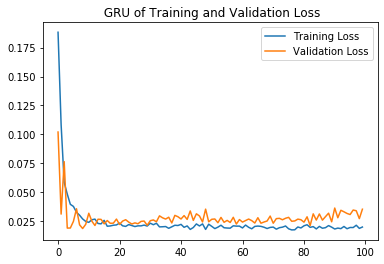

In [11]:
file = open('C:/Users/Administrator/Desktop/GRU_RON_LOSS_weights.txt', 'w' )  # 参数提取
for v in model_GRU.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title(' GRU of Training and Validation Loss')
plt.legend()
#plt.show()
plt.savefig(r"C:\Users\Administrator\Desktop\GRU_Loss.jpg")

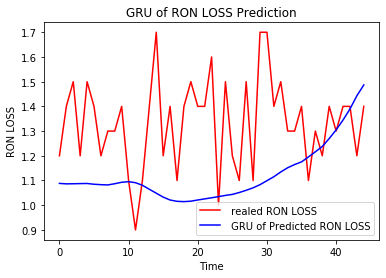

In [12]:
################## predict ######################
# 测试集输入模型进行预测
predicted_RON_LOSS = model_GRU.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_RON_LOSS = sc_y.inverse_transform(y_test)
# 画出真实数据和预测数据的对比曲线
plt.plot(real_RON_LOSS, color='red', label=' realed RON LOSS')
plt.plot(predicted_RON_LOSS, color='blue', label=' GRU of Predicted RON LOSS')
plt.title('GRU of RON LOSS Prediction')
plt.xlabel('Time')
plt.ylabel('RON LOSS')
plt.legend()
#plt.show()
plt.savefig(r"C:\Users\Administrator\Desktop\GRU_Lpredict.jpg")

In [13]:
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_RON_LOSS, real_RON_LOSS)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_RON_LOSS, real_RON_LOSS))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_RON_LOSS, real_RON_LOSS)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.090955
均方根误差: 0.301587
平均绝对误差: 0.241143


ValueError: cannot reindex from a duplicate axis

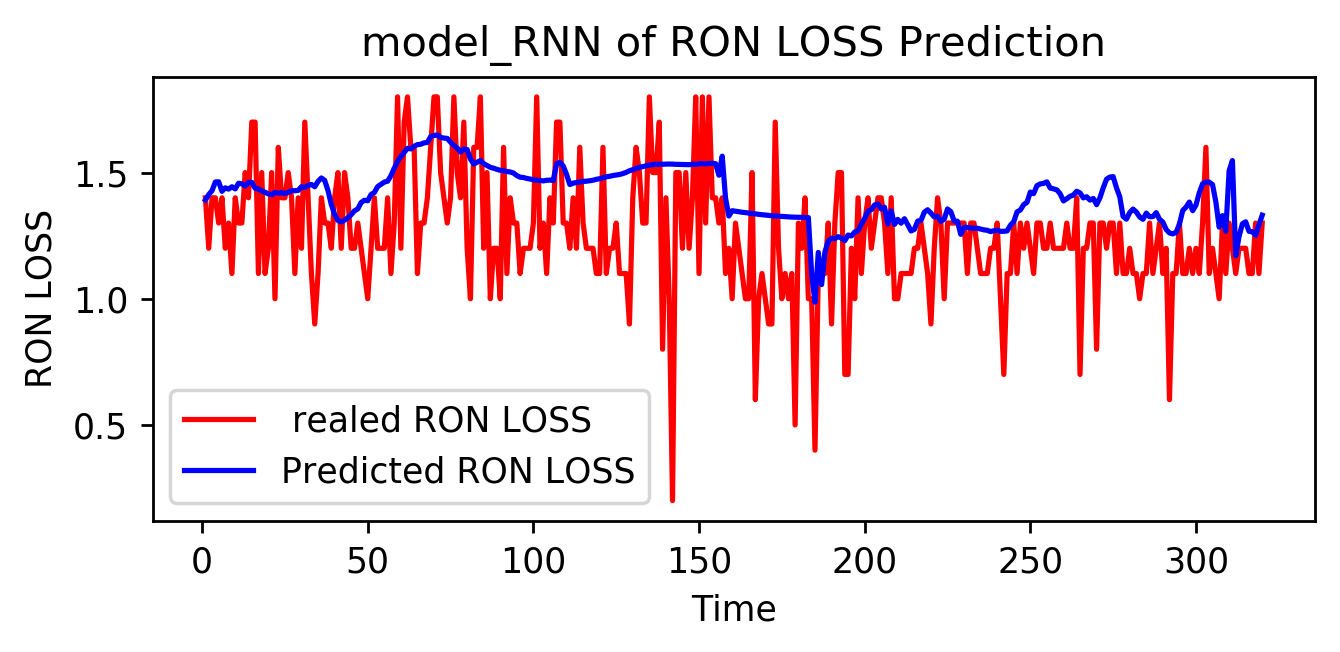

In [14]:
data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data = data.sort_values('id', ascending = False)
all_samples = data.iloc[: , : ].values  # 所有样本的特征作为测试集

# 归一化
sc_x = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc_y = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
test_set_scaled_x = sc_x.fit_transform(all_samples[:,2:])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_scaled_y = sc_y.fit_transform(all_samples[:,1:2])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化

x_test = []
y_test = []

for i in range(5, len(test_set_scaled_x)):
    x_test.append(test_set_scaled_x[i - 5:i, :])
    y_test.append(test_set_scaled_x[i, :])

# 将训练集由list格式变为array格式
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], 5, 26))

################## predict ######################
# 测试集输入模型进行预测
m = ["model_RNN" , "model_LSTM" , "model_GRU"] 
f = [model_RNN , model_LSTM , model_GRU]
fig = plt.figure(figsize = (6,8) , dpi = 250 )
for i , k in enumerate(f) :
    predicted_RON_LOSS = k.predict(x_test)
    # 对预测数据还原---从（0，1）反归一化到原始范围
    predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
    # 对真实数据还原---从（0，1）反归一化到原始范围
    real_RON_LOSS = all_samples[5:,1:2]

    # 画出真实数据和预测数据的对比曲线
    plt.subplot(3,1,i+1)
    plt.plot(range(320,0,-1),real_RON_LOSS.ravel(), color='red', label=' realed RON LOSS')
    plt.plot(range(320,0,-1),predicted_RON_LOSS.ravel(), color='blue', label='Predicted RON LOSS')
    plt.title('{} of RON LOSS Prediction'.format(m[i]))
    plt.xlabel('Time')
    plt.ylabel('RON LOSS')
    plt.legend(loc = "best")
    real_RON_LOSS = pd.DataFrame(real_RON_LOSS )
    predicted_RON_LOSS = pd.DataFrame(predicted_RON_LOSS)
    w = pd.concat([real_RON_LOSS,predicted_RON_LOSS] ,axis = 1)
    w = pd.DataFrame(w , columns=['real_RON_LOSS','predicted_RON_LOSS'])
    w["id1"] = w.index 
    w["id"] = 320 -  w['id1']
    w = w.drop(columns = "id1")
    w = pd.DataFrame(w , columns=["id" ,'real_RON_LOSS','predicted_RON_LOSS'])
    w = w.sort_values('id', ascending = False)
    w.to_csv(r"C:\Users\Administrator\Desktop\{}_RON_VS_Pre.csv".format(m[i]) ,index=None)
fig.tight_layout()
#plt.show()
plt.savefig(r"C:\Users\Administrator\Desktop\all_samples_predict.jpg")

In [15]:
data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data = data.sort_values('id', ascending = False)
all_samples = data.iloc[: , : ].values  # 所有样本的特征作为测试集

# 归一化
sc_x = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc_y = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
test_set_scaled_x = sc_x.fit_transform(all_samples[:,2:])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_scaled_y = sc_y.fit_transform(all_samples[:,1:2])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化

x_test = []
y_test = []

for i in range(5, len(test_set_scaled_x)):
    x_test.append(test_set_scaled_x[i - 5:i, :])
    y_test.append(test_set_scaled_x[i, :])

# 将训练集由list格式变为array格式
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], 5, 26))

################## predict ######################
# 测试集输入模型进行预测
m = ["model_RNN" , "model_LSTM" , "model_GRU"] 
f = [model_RNN , model_LSTM , model_GRU]
fig = plt.figure(figsize = (6,8) , dpi = 250 )

predicted_RON_LOSS = model_RNN.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_RON_LOSS = all_samples[5:,1:2]

real_RON_LOSS = pd.DataFrame(real_RON_LOSS )
predicted_RON_LOSS = pd.DataFrame(predicted_RON_LOSS)

<Figure size 1500x2000 with 0 Axes>

In [24]:
w = pd.concat([real_RON_LOSS,predicted_RON_LOSS] ,axis = 1)
w

,0,0
0,1.3,1.331164
1,1.1,1.293238
2,1.3,1.251338
3,1.1,1.265345
4,1.1,1.267485
...,...,...
315,1.3,1.463358
316,1.4,1.462760
317,1.4,1.428212
318,1.2,1.412693


In [26]:
w = pd.DataFrame(w)
w.columns = ["real_RON_LOSS","predicted_RON_LOSS"]
w

,real_RON_LOSS,predicted_RON_LOSS
0,1.3,1.331164
1,1.1,1.293238
2,1.3,1.251338
3,1.1,1.265345
4,1.1,1.267485
...,...,...
315,1.3,1.463358
316,1.4,1.462760
317,1.4,1.428212
318,1.2,1.412693


In [17]:
w = pd.DataFrame(w , columns=['real_RON_LOSS','predicted_RON_LOSS'])

ValueError: cannot reindex from a duplicate axis

In [16]:
w["id1"] = w.index 
w["id"] = 320 -  w['id1']
w = w.drop(columns = "id1")
w = pd.DataFrame(w , columns=["id" ,'real_RON_LOSS','predicted_RON_LOSS'])
w = w.sort_values('id', ascending = False)

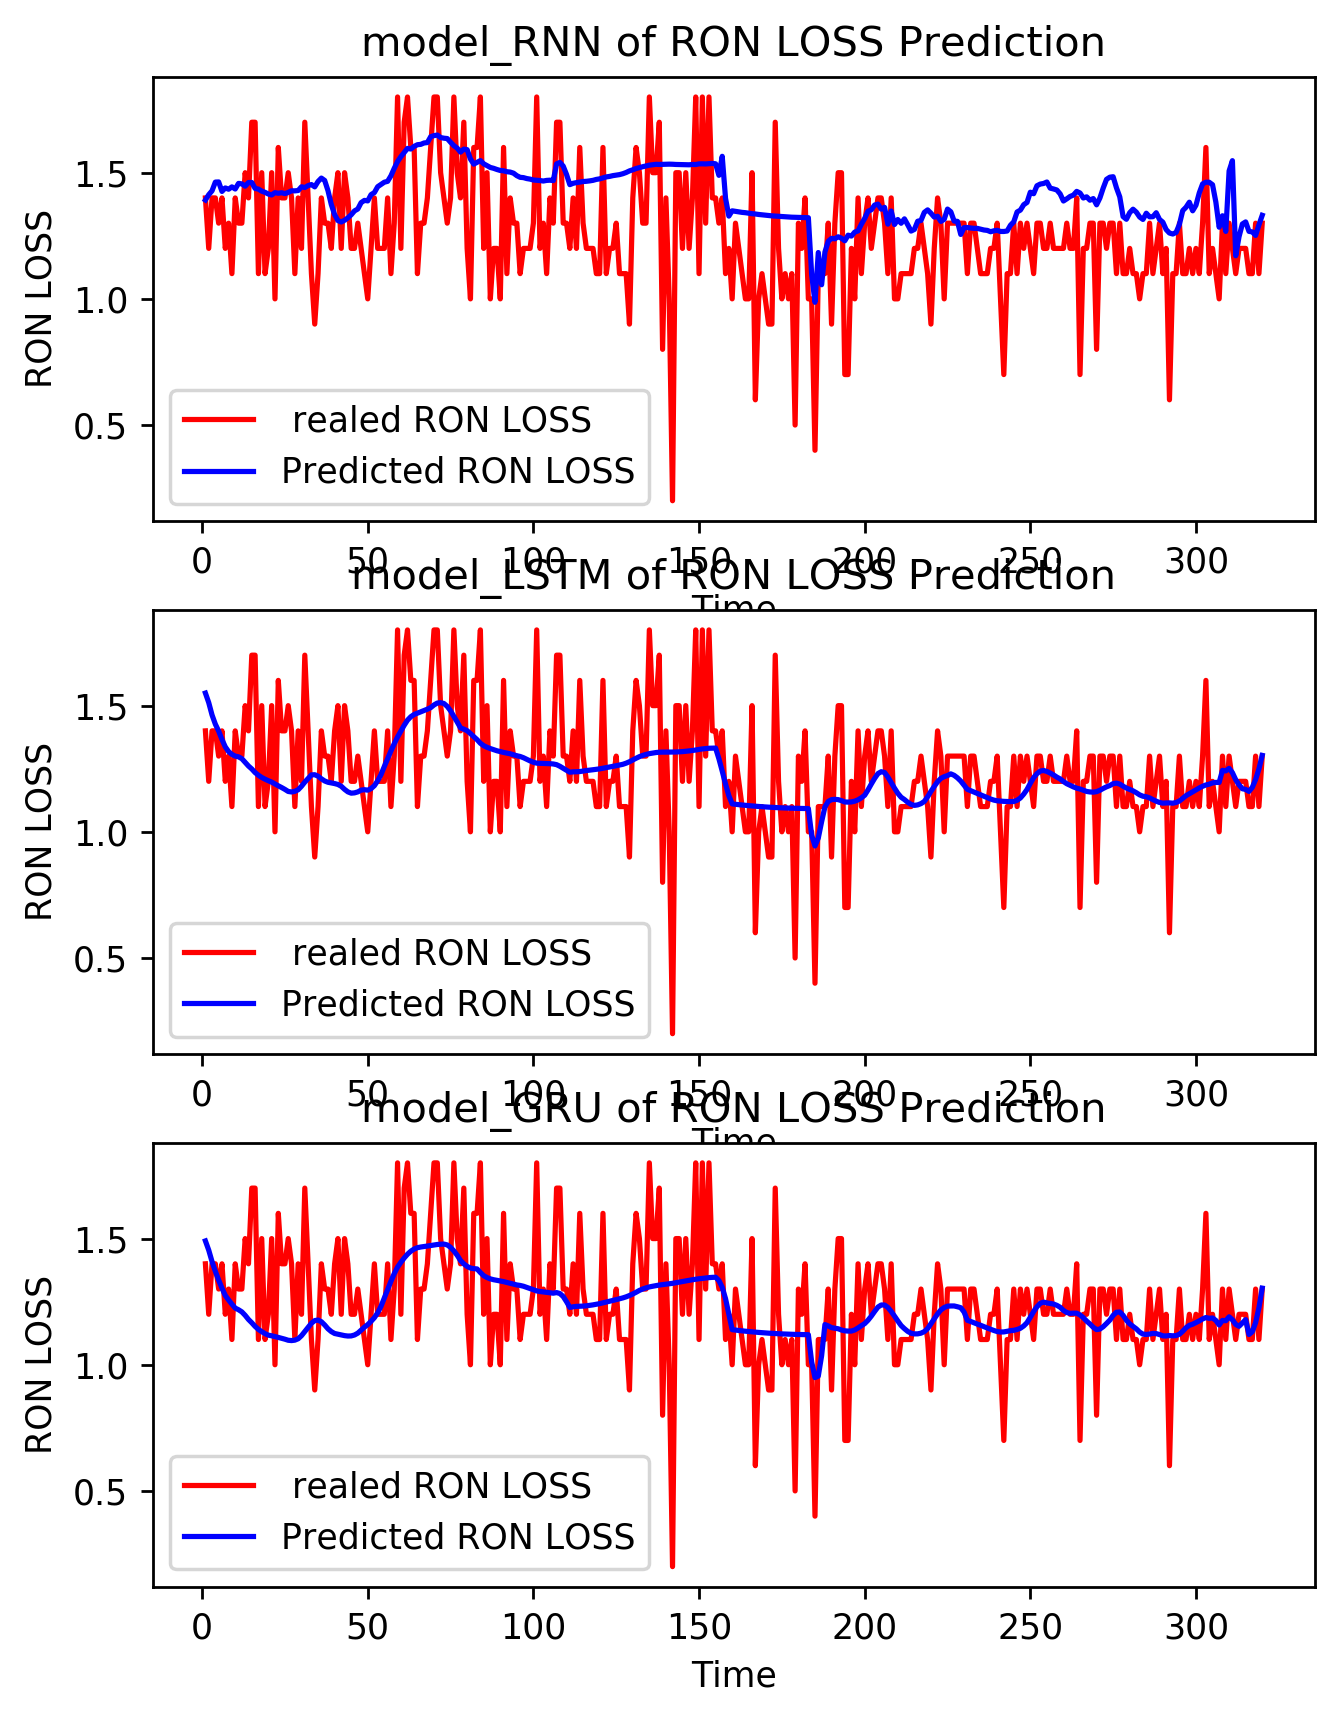

In [28]:
data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data = data.sort_values('id', ascending = False)
all_samples = data.iloc[: , : ].values  # 所有样本的特征作为测试集

# 归一化
sc_x = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc_y = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
test_set_scaled_x = sc_x.fit_transform(all_samples[:,2:])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_scaled_y = sc_y.fit_transform(all_samples[:,1:2])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化

x_test = []
y_test = []

for i in range(5, len(test_set_scaled_x)):
    x_test.append(test_set_scaled_x[i - 5:i, :])
    y_test.append(test_set_scaled_x[i, :])

# 将训练集由list格式变为array格式
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], 5, 26))

################## predict ######################
# 测试集输入模型进行预测
m = ["model_RNN" , "model_LSTM" , "model_GRU"] 
f = [model_RNN , model_LSTM , model_GRU]
fig = plt.figure(figsize = (6,8) , dpi = 250 )
for i , k in enumerate(f) :
    predicted_RON_LOSS = k.predict(x_test)
    # 对预测数据还原---从（0，1）反归一化到原始范围
    predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
    # 对真实数据还原---从（0，1）反归一化到原始范围
    real_RON_LOSS = all_samples[5:,1:2]

    # 画出真实数据和预测数据的对比曲线
    plt.subplot(3,1,i+1)
    plt.plot(range(320,0,-1),real_RON_LOSS.ravel(), color='red', label=' realed RON LOSS')
    plt.plot(range(320,0,-1),predicted_RON_LOSS.ravel(), color='blue', label='Predicted RON LOSS')
    plt.title('{} of RON LOSS Prediction'.format(m[i]))
    plt.xlabel('Time')
    plt.ylabel('RON LOSS')
    plt.legend(loc = "best")
    real_RON_LOSS = pd.DataFrame(real_RON_LOSS )
    predicted_RON_LOSS = pd.DataFrame(predicted_RON_LOSS)
    w = pd.concat([real_RON_LOSS,predicted_RON_LOSS] ,axis = 1)
    w = pd.DataFrame(w)
    w.columns = ["real_RON_LOSS","predicted_RON_LOSS"]
    w["id1"] = w.index 
    w["id"] = 320 -  w['id1']
    w = w.drop(columns = "id1")
    w = pd.DataFrame(w , columns=["id" ,'real_RON_LOSS','predicted_RON_LOSS'])
    w = w.sort_values('id', ascending = False)

In [29]:
w

,id,real_RON_LOSS,predicted_RON_LOSS
0,320,1.3,1.303599
1,319,1.1,1.225338
2,318,1.3,1.166954
3,317,1.1,1.130960
4,316,1.1,1.119813
...,...,...,...
315,5,1.3,1.335492
316,4,1.4,1.370217
317,3,1.4,1.408721
318,2,1.2,1.454161


In [ ]:
w.to_csv(r"C:\Users\Administrator\Desktop\{}_RON_VS_Pre.csv".format(m[i]) ,index=None)
fig.tight_layout()
#plt.show()
plt.savefig(r"C:\Users\Administrator\Desktop\all_samples_predict.jpg")

model_RNN的均方误差: 0.068095
model_RNN的均方根误差: 0.260950
model_RNN的平均绝对误差: 0.207627
model_LSTM的均方误差: 0.043179
model_LSTM的均方根误差: 0.207795
model_LSTM的平均绝对误差: 0.151089
model_GRU的均方误差: 0.045462
model_GRU的均方根误差: 0.213218
model_GRU的平均绝对误差: 0.154941


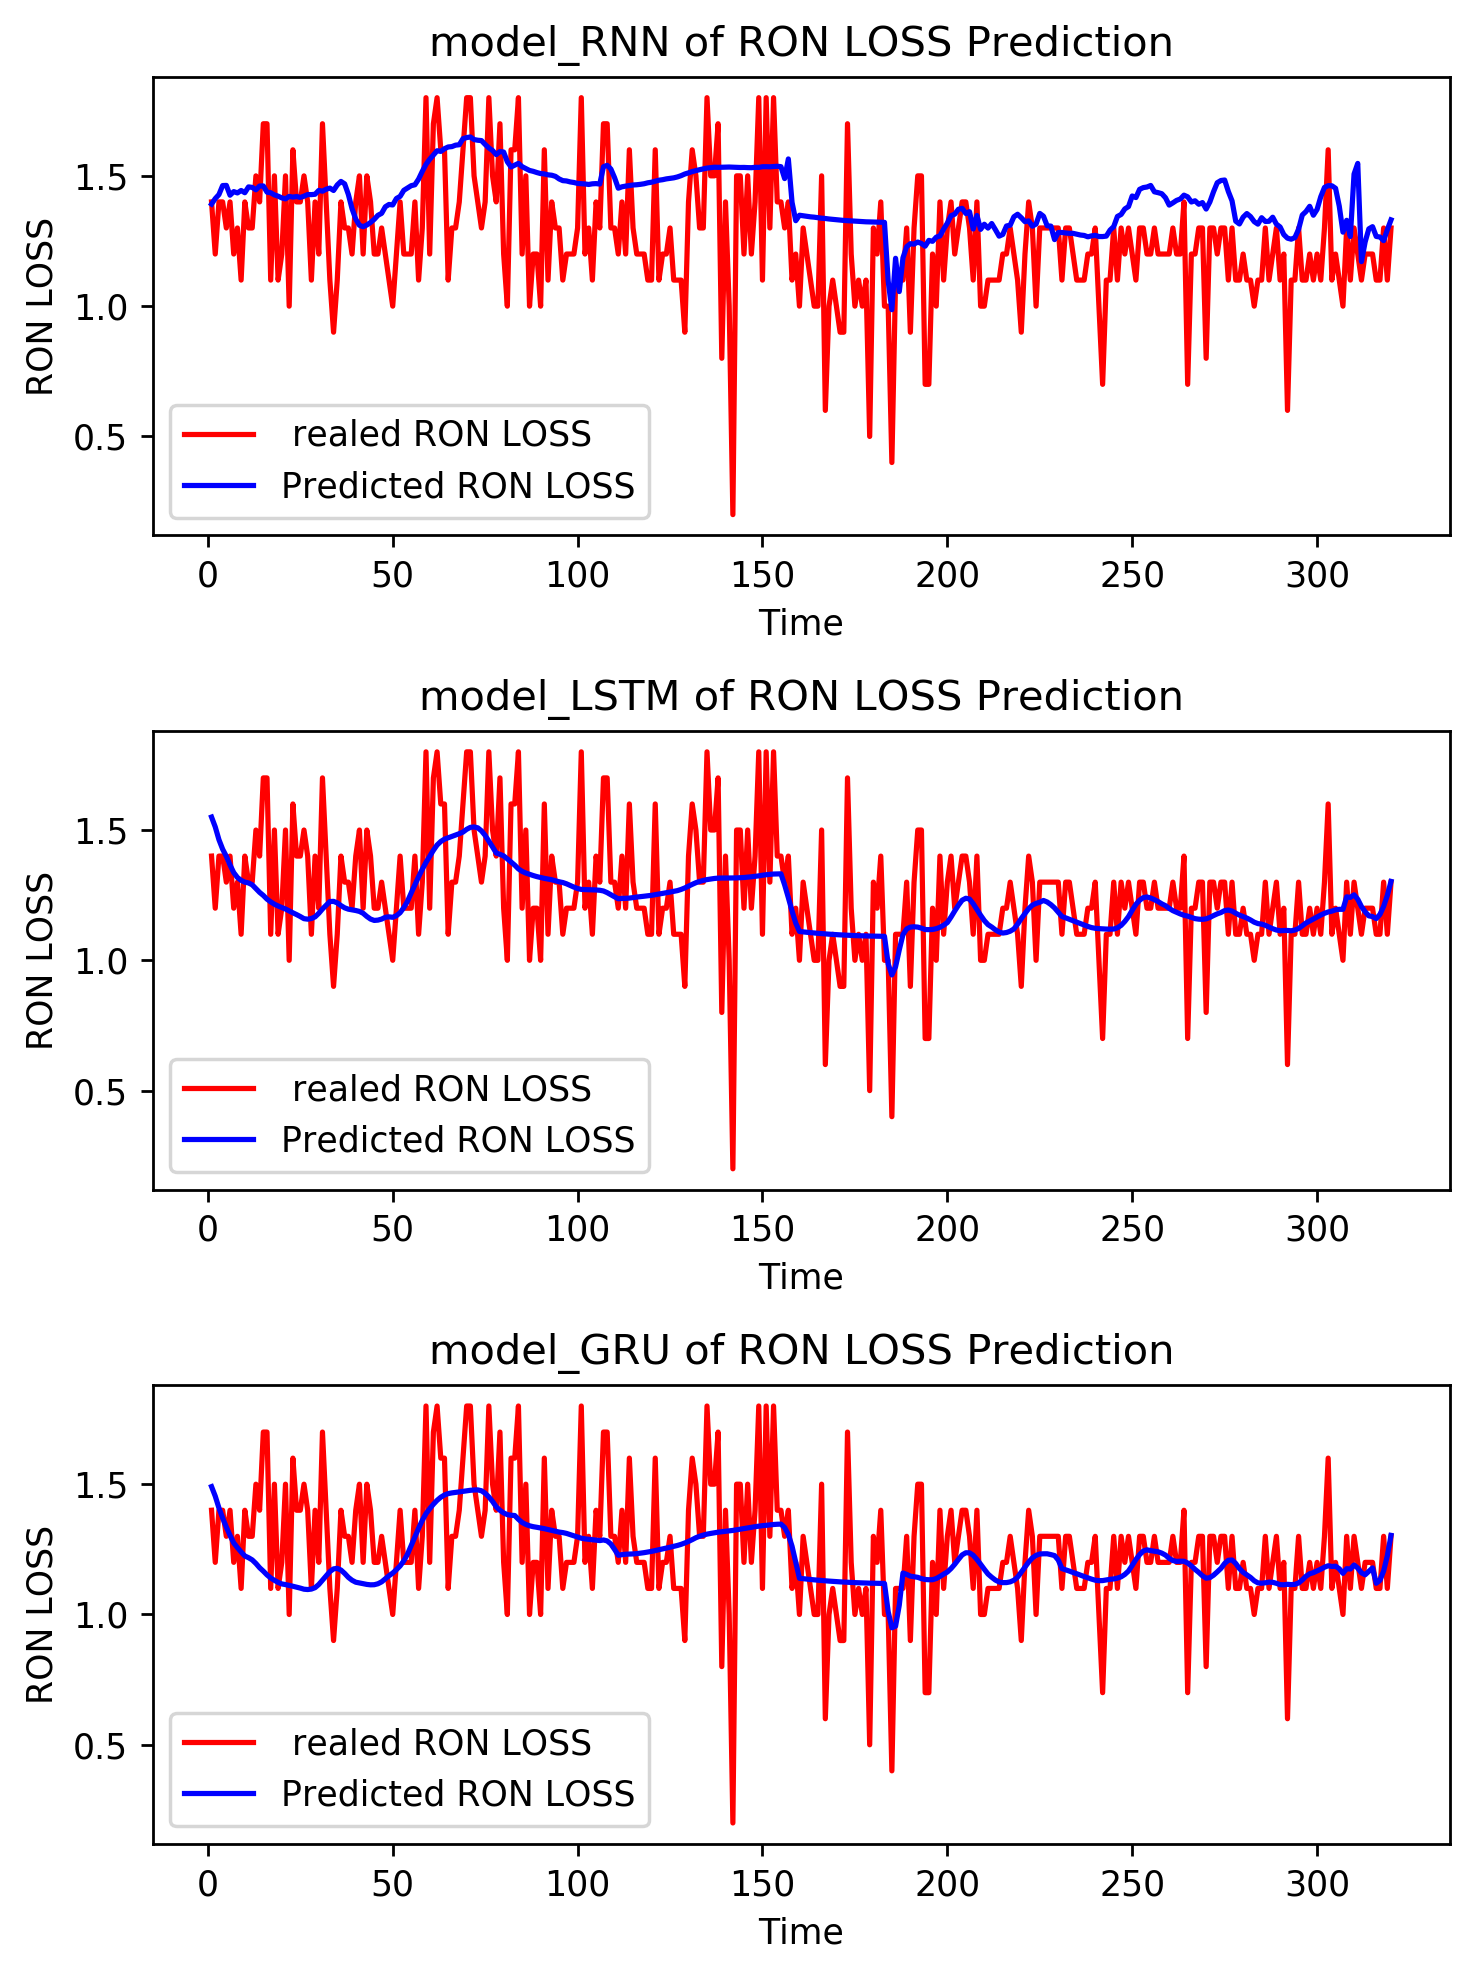

In [31]:
data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
data = data.sort_values('id', ascending = False)
all_samples = data.iloc[: , : ].values  # 所有样本的特征作为测试集

# 归一化
sc_x = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
sc_y = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
test_set_scaled_x = sc_x.fit_transform(all_samples[:,2:])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_scaled_y = sc_y.fit_transform(all_samples[:,1:2])  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化

x_test = []
y_test = []

for i in range(5, len(test_set_scaled_x)):
    x_test.append(test_set_scaled_x[i - 5:i, :])
    y_test.append(test_set_scaled_x[i, :])

# 将训练集由list格式变为array格式
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], 5, 26))

################## predict ######################
# 测试集输入模型进行预测
m = ["model_RNN" , "model_LSTM" , "model_GRU"] 
f = [model_RNN , model_LSTM , model_GRU]
fig = plt.figure(figsize = (6,8) , dpi = 250 )
for i , k in enumerate(f) :
    predicted_RON_LOSS = k.predict(x_test)
    # 对预测数据还原---从（0，1）反归一化到原始范围
    predicted_RON_LOSS = sc_y.inverse_transform(predicted_RON_LOSS)
    # 对真实数据还原---从（0，1）反归一化到原始范围
    real_RON_LOSS = all_samples[5:,1:2]

    # 画出真实数据和预测数据的对比曲线
    plt.subplot(3,1,i+1)
    plt.plot(range(320,0,-1),real_RON_LOSS.ravel(), color='red', label=' realed RON LOSS')
    plt.plot(range(320,0,-1),predicted_RON_LOSS.ravel(), color='blue', label='Predicted RON LOSS')
    plt.title('{} of RON LOSS Prediction'.format(m[i]))
    plt.xlabel('Time')
    plt.ylabel('RON LOSS')
    plt.legend(loc = "best")
    real_RON_LOSS = pd.DataFrame(real_RON_LOSS )
    predicted_RON_LOSS = pd.DataFrame(predicted_RON_LOSS)
    w = pd.concat([real_RON_LOSS,predicted_RON_LOSS] ,axis = 1)
    w = pd.DataFrame(w)
    w.columns = ["real_RON_LOSS","predicted_RON_LOSS"]
    w["id1"] = w.index 
    w["id"] = 320 -  w['id1']
    w = w.drop(columns = "id1")
    w = pd.DataFrame(w , columns=["id" ,'real_RON_LOSS','predicted_RON_LOSS'])
    w = w.sort_values('id', ascending = False)
    w.to_csv(r"C:\Users\Administrator\Desktop\{}_RON_VS_Pre.csv".format(m[i]) ,index=None)
    ##########evaluate##############
    # calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
    mse = mean_squared_error(predicted_RON_LOSS, real_RON_LOSS)
    # calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
    rmse = math.sqrt(mean_squared_error(predicted_RON_LOSS, real_RON_LOSS))
    # calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
    mae = mean_absolute_error(predicted_RON_LOSS, real_RON_LOSS)
    print('%s的均方误差: %.6f' % (m[i],mse))
    print('%s的均方根误差: %.6f' % (m[i],rmse))
    print('%s的平均绝对误差: %.6f' % (m[i],mae))
fig.tight_layout()

E:\environment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
E:\environment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
E:\environment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
E:\environment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

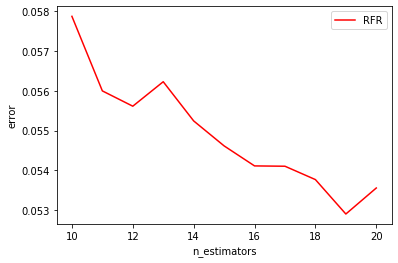

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv")
x = data.iloc[:,2:]
y = data.iloc[:,1:2]
error = []
for i in range(10,21):
    regressor = RandomForestRegressor(n_estimators=i,random_state=0)
    mse = cross_val_score(regressor, x, y, cv=10,scoring = "neg_mean_squared_error").mean()
    mse = mse * -1
    error.append(mse)
plt.plot(range(10,21),error,color = "red" ,label = "RFR")
plt.xlabel("n_estimators")
plt.ylabel("error")
plt.legend(loc = "best")

E:\environment\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
E:\environment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
E:\environment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
E:\environment\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using r

19颗随机森林10折交叉验证后的均方误差: 0.052907


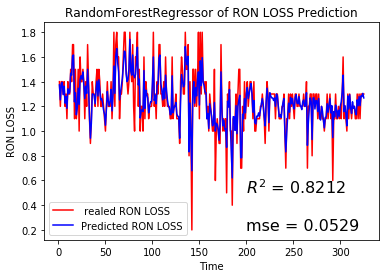

In [38]:
####选择均方误差最小时的随机树的棵树#####
regressor = RandomForestRegressor(n_estimators=19,random_state=0)

#####用n_estimatirs = 19 来拟合RON_LOSS

rg = regressor.fit(x , y)
y_hat = rg.predict(x)
y_hat.shape
mse_19 = cross_val_score(regressor, x, y, cv=10,scoring = "neg_mean_squared_error").mean()
mse_19 = mse_19 * -1
plt.plot(range(1,326,1),y, color='red', label=' realed RON LOSS')
plt.plot(range(1,326,1),y_hat, color='blue', label='Predicted RON LOSS')
plt.title('RandomForestRegressor of RON LOSS Prediction')
plt.annotate('mse = {}'.format(round(mse_19,4)),xy=(200,0.2),xytext=(200,0.2),fontsize=16)
plt.annotate('$R^2$ = {}'.format(round(R,4)),xy=(200,0.5),xytext=(200,0.5),fontsize=16)
plt.xlabel('Time')
plt.ylabel('RON LOSS')
plt.legend(loc = 3)
#plt.show()
print('19颗随机森林10折交叉验证后的均方误差: %.6f' % mse_19)

In [148]:
import pandas as pd
data_LSTM_RON = pd.read_csv(r"C:\Users\Administrator\Desktop\model_LSTM_RON_VS_Pre.csv").sort_values('id')
data_LSTM_RON.index = range(data_LSTM_RON.shape[0])
data_LSTM_RON

data_ps = pd.read_csv(r"C:\Users\Administrator\Desktop\table1_end_data.csv").iloc[:320,9:10]
data_ps

data_var = pd.read_csv(r"C:\Users\Administrator\Desktop\x_fe_poly.csv").iloc[:320,2:]
data_var.shape

p = pd.concat([data_LSTM_RON,data_ps,data_var] ,axis = 1)
p.head()
p.to_csv(r"C:\Users\Administrator\Desktop\four_solve.csv" ,index = None)

In [192]:
p

,id,real_RON_LOSS,predicted_RON_LOSS,P_S,var1,var2,var3,var4,var5,var6,...,var7.1,var18,var19,var20,var21,var22,var23,var24,var25,var26
0,1,1.4,1.549775,3.2,-4.411884e+19,-9.270722e+19,4.639961e+19,1.737206e+19,-2.114099e+18,5.749355e+18,...,5.789957e+16,1.131535e+16,-2.847478e+15,-6.093998e+15,5.749498e+16,-8.061591e+15,-5.816416e+16,-6.786401e+15,8.109621e+16,2.882054e+15
1,2,1.2,1.512022,3.2,-4.643583e+19,-9.015599e+19,4.496504e+19,1.683166e+19,-2.096311e+18,5.319139e+18,...,6.254465e+16,3.374477e+15,1.572202e+16,1.174927e+14,3.523500e+16,1.690739e+16,-4.595063e+16,3.607794e+15,6.623486e+16,6.350945e+15
2,3,1.4,1.462994,3.2,-4.735121e+19,-8.914367e+19,4.439428e+19,1.661155e+19,-2.086915e+18,5.121913e+18,...,5.850757e+16,4.235998e+15,1.506324e+16,-1.143893e+15,3.066895e+16,1.829504e+16,-3.949591e+16,4.190645e+15,5.769640e+16,6.167659e+15
3,4,1.4,1.426506,3.2,-4.964681e+19,-8.662505e+19,4.297598e+19,1.607061e+19,-2.066216e+18,4.638971e+18,...,4.859134e+16,1.136542e+16,1.221278e+16,-7.095368e+15,1.988719e+16,2.299788e+16,-2.223722e+16,6.558515e+15,3.273087e+16,4.738874e+15
4,5,1.3,1.399049,3.2,-5.056552e+19,-8.560313e+19,4.239896e+19,1.584554e+19,-2.054296e+18,4.432375e+18,...,4.529593e+16,1.433613e+16,8.187383e+15,-1.128476e+16,1.725266e+16,2.275086e+16,-1.559628e+16,6.431419e+15,2.378960e+16,3.325614e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,316,1.1,1.160058,9.0,3.689189e+19,1.234561e+20,1.265007e+20,-9.060777e+18,-2.546975e+18,9.020258e+17,...,-3.743743e+16,-9.179575e+15,2.020963e+13,-1.748320e+16,1.501056e+16,-6.397940e+16,1.122946e+17,1.755708e+17,6.933926e+16,-4.417618e+16
316,317,1.1,1.176092,5.3,3.417016e+19,1.233697e+20,1.255185e+20,-8.266296e+18,-1.859708e+18,6.296309e+17,...,-7.869252e+16,-1.885692e+16,-8.245509e+16,-5.379099e+15,-1.723386e+16,-1.521068e+16,3.078923e+16,4.226593e+16,7.089077e+15,2.750504e+15
317,318,1.3,1.206932,3.3,3.237264e+19,1.231177e+20,1.244909e+20,-7.631705e+18,-1.371026e+18,4.392755e+17,...,-6.545904e+16,-1.478267e+16,-1.026631e+17,-3.073932e+15,-4.140349e+16,1.699966e+16,-6.055490e+15,-2.794716e+15,1.418363e+15,1.128646e+15
318,319,1.1,1.249142,3.3,3.059655e+19,1.228650e+20,1.234754e+20,-7.005373e+18,-8.887600e+17,2.518763e+17,...,-5.278400e+16,-1.121207e+16,-1.108720e+17,-6.404387e+14,-5.565859e+16,4.017046e+16,-3.247549e+16,-3.658663e+16,-3.584958e+15,3.100134e+14


In [172]:
a = [3 , 3.5 , 4 , 4.5 , 5 ]
for k ,j  in enumerate(a):
    condition_sample_1 = []
    n_1 = 0
    for i in range(p.shape[0]):
        if p.iloc[i,3] <= a[k]:
            n_1+=1
            sample_1 = p.iloc[i ,0 ]
            sample_1 = int(sample_1)
            condition_sample_1.append(sample_1)
    print(n_1)
    xx_1 = []
    for i in condition_sample_1:
        xx_1.append(p.iloc[i-1,:])
    xxx_1 = pd.DataFrame(xx_1)
    xxx_1.sort_values('id' , ascending = False ,inplace = True )
    xxx_1.index = range(xxx_1.shape[0])

            xxx_1['delta'] = round(1 / (xxx_1.iloc[:,1] / xxx_1.iloc[:,1].diff() -1), 2 )
            n_12 = 0
            condition_sample_12 = []
            for i in range(xxx_1.shape[0]):
                if xxx_1.iloc[i, -1 ] > 0.3:
                    n_12+=1
                    sample_12 = p.iloc[i ,0 ]
                    sample_12 = int(sample_12)
                    condition_sample_12.append(sample_12)

            xx_12 = []
            for i in condition_sample_12:
                xx_12.append(xxx_1.iloc[i-1,:])
            xxx_12 = pd.DataFrame(xx_12)
            mean_12_s = xxx_12.mean()[3:4]
            mean_12_var26 = xxx_12.mean()[4:-1]
            std_12_var26 = np.sqrt(xxx_12.var()[4:-1])


            delta_2 = mean_12_var26 + 1.96 * std_12_var26 / n_12

            delta_1 = mean_12_var26 - 1.96 * std_12_var26 / n_12

            delta = pd.concat([delta_1,mean_12_var26,delta_2],axis = 1 ).T
            delta = delta / 10**15
            delta.index = ["delta_1" ,"mean" , "delta_2"]
            delta["range_var26"] = delta.index
            mid = delta['range_var26']
            delta.drop(labels=['range_var26'], axis=1,inplace = True)
            delta.insert(0, 'range_var26', mid)
            #print("在损失预测优化模型下，产品硫含量不大于{}的前提下,经过第一次筛选还有{}个样本，第二次筛选还有{}个样本".format((a[k], len(n_1) , len(n_12))))
            delta.to_csv(r"C:\Users\Administrator\Desktop\delta_var26_s_{}.csv".format(a[k]) , index = None)

TypeError: object of type 'int' has no len()

In [188]:
delta_var26_s_1 = pd.read_csv(r"C:/Users/Administrator/Desktop/delta_var26_s_3.5.csv")

delta_var26_s_2 = pd.read_csv(r"C:/Users/Administrator/Desktop/delta_var26_s_4.csv")
delta_var26_s_3 = pd.read_csv(r"C:/Users/Administrator/Desktop/delta_var26_s_4.5.csv")
delta_var26_s_4 = pd.read_csv(r"C:/Users/Administrator/Desktop/delta_var26_s_5.csv")
all_delta = pd.concat([delta_var26_s_1,delta_var26_s_2,delta_var26_s_3,delta_var26_s_4] ,axis = 0)

all_delta.to_csv(r"C:\Users\Administrator\Desktop\delta_var26_all.csv" , index = None)

In [197]:
p

,id,real_RON_LOSS,predicted_RON_LOSS,P_S,var1,var2,var3,var4,var5,var6,...,var7.1,var18,var19,var20,var21,var22,var23,var24,var25,var26
0,1,1.4,1.549775,3.2,-4.411884e+19,-9.270722e+19,4.639961e+19,1.737206e+19,-2.114099e+18,5.749355e+18,...,5.789957e+16,1.131535e+16,-2.847478e+15,-6.093998e+15,5.749498e+16,-8.061591e+15,-5.816416e+16,-6.786401e+15,8.109621e+16,2.882054e+15
1,2,1.2,1.512022,3.2,-4.643583e+19,-9.015599e+19,4.496504e+19,1.683166e+19,-2.096311e+18,5.319139e+18,...,6.254465e+16,3.374477e+15,1.572202e+16,1.174927e+14,3.523500e+16,1.690739e+16,-4.595063e+16,3.607794e+15,6.623486e+16,6.350945e+15
2,3,1.4,1.462994,3.2,-4.735121e+19,-8.914367e+19,4.439428e+19,1.661155e+19,-2.086915e+18,5.121913e+18,...,5.850757e+16,4.235998e+15,1.506324e+16,-1.143893e+15,3.066895e+16,1.829504e+16,-3.949591e+16,4.190645e+15,5.769640e+16,6.167659e+15
3,4,1.4,1.426506,3.2,-4.964681e+19,-8.662505e+19,4.297598e+19,1.607061e+19,-2.066216e+18,4.638971e+18,...,4.859134e+16,1.136542e+16,1.221278e+16,-7.095368e+15,1.988719e+16,2.299788e+16,-2.223722e+16,6.558515e+15,3.273087e+16,4.738874e+15
4,5,1.3,1.399049,3.2,-5.056552e+19,-8.560313e+19,4.239896e+19,1.584554e+19,-2.054296e+18,4.432375e+18,...,4.529593e+16,1.433613e+16,8.187383e+15,-1.128476e+16,1.725266e+16,2.275086e+16,-1.559628e+16,6.431419e+15,2.378960e+16,3.325614e+15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,316,1.1,1.160058,9.0,3.689189e+19,1.234561e+20,1.265007e+20,-9.060777e+18,-2.546975e+18,9.020258e+17,...,-3.743743e+16,-9.179575e+15,2.020963e+13,-1.748320e+16,1.501056e+16,-6.397940e+16,1.122946e+17,1.755708e+17,6.933926e+16,-4.417618e+16
316,317,1.1,1.176092,5.3,3.417016e+19,1.233697e+20,1.255185e+20,-8.266296e+18,-1.859708e+18,6.296309e+17,...,-7.869252e+16,-1.885692e+16,-8.245509e+16,-5.379099e+15,-1.723386e+16,-1.521068e+16,3.078923e+16,4.226593e+16,7.089077e+15,2.750504e+15
317,318,1.3,1.206932,3.3,3.237264e+19,1.231177e+20,1.244909e+20,-7.631705e+18,-1.371026e+18,4.392755e+17,...,-6.545904e+16,-1.478267e+16,-1.026631e+17,-3.073932e+15,-4.140349e+16,1.699966e+16,-6.055490e+15,-2.794716e+15,1.418363e+15,1.128646e+15
318,319,1.1,1.249142,3.3,3.059655e+19,1.228650e+20,1.234754e+20,-7.005373e+18,-8.887600e+17,2.518763e+17,...,-5.278400e+16,-1.121207e+16,-1.108720e+17,-6.404387e+14,-5.565859e+16,4.017046e+16,-3.247549e+16,-3.658663e+16,-3.584958e+15,3.100134e+14


In [227]:
a = 3
condition_sample_1 = []
n_1 = 0
for i in range(p.shape[0]):
    if p.iloc[i,3] <= 4:
        n_1+=1
        sample_1 = p.iloc[i ,0 ]
        condition_sample_1.append(sample_1)
n_1

225

In [228]:
xx_1 = []
for i in condition_sample_1:
    xx_1.append(p.iloc[i-1,:])
xxx_1 = pd.DataFrame(xx_1)
xxx_1.sort_values('id' , ascending = False ,inplace = True )
xxx_1.index = range(xxx_1.shape[0])
xxx_1['delta'] = round(1 / (xxx_1.iloc[:,1] / xxx_1.iloc[:,1].diff() -1), 2 )

In [216]:
xxx_1

,id,real_RON_LOSS,predicted_RON_LOSS,P_S,var1,var2,var3,var4,var5,var6,...,var18,var19,var20,var21,var22,var23,var24,var25,var26,delta
0,320.0,1.3,1.302758,4.3,2.791107e+19,1.224607e+20,1.219331e+20,-6.079534e+18,-1.756545e+17,-3.249390e+16,...,-6.219835e+15,-1.036478e+17,1.394106e+15,-6.136504e+16,5.394991e+16,-5.215002e+16,-6.159667e+16,-8.138492e+15,-7.806857e+14,NaN
1,319.0,1.1,1.249142,3.3,3.059655e+19,1.228650e+20,1.234754e+20,-7.005373e+18,-8.887600e+17,2.518763e+17,...,-1.121207e+16,-1.108720e+17,-6.404387e+14,-5.565859e+16,4.017046e+16,-3.247549e+16,-3.658663e+16,-3.584958e+15,3.100134e+14,-0.04
2,318.0,1.3,1.206932,3.3,3.237264e+19,1.231177e+20,1.244909e+20,-7.631705e+18,-1.371026e+18,4.392755e+17,...,-1.478267e+16,-1.026631e+17,-3.073932e+15,-4.140349e+16,1.699966e+16,-6.055490e+15,-2.794716e+15,1.418363e+15,1.128646e+15,-0.03
3,315.0,1.2,1.167853,3.3,3.891664e+19,1.235308e+20,1.272749e+20,-9.603920e+18,-2.977846e+18,1.084660e+18,...,4.491394e+16,3.058000e+17,2.298250e+16,1.277626e+17,-2.101341e+16,-4.930415e+16,-1.097040e+17,-6.203658e+16,4.081777e+16,-0.03
4,310.0,1.3,1.251407,3.2,4.661034e+19,4.799835e+19,-2.049696e+19,3.170133e+19,1.009947e+19,-1.699022e+18,...,-1.768747e+16,2.863802e+16,-5.443791e+16,-4.779045e+16,-2.675627e+16,-9.123858e+15,-1.930945e+15,2.835782e+15,5.727348e+15,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,5.0,1.3,1.399049,3.2,-5.056552e+19,-8.560313e+19,4.239896e+19,1.584554e+19,-2.054296e+18,4.432375e+18,...,1.433613e+16,8.187383e+15,-1.128476e+16,1.725266e+16,2.275086e+16,-1.559628e+16,6.431419e+15,2.378960e+16,3.325614e+15,0.02
260,4.0,1.4,1.426506,3.2,-4.964681e+19,-8.662505e+19,4.297598e+19,1.607061e+19,-2.066216e+18,4.638971e+18,...,1.136542e+16,1.221278e+16,-7.095368e+15,1.988719e+16,2.299788e+16,-2.223722e+16,6.558515e+15,3.273087e+16,4.738874e+15,0.02
261,3.0,1.4,1.462994,3.2,-4.735121e+19,-8.914367e+19,4.439428e+19,1.661155e+19,-2.086915e+18,5.121913e+18,...,4.235998e+15,1.506324e+16,-1.143893e+15,3.066895e+16,1.829504e+16,-3.949591e+16,4.190645e+15,5.769640e+16,6.167659e+15,0.03
262,2.0,1.2,1.512022,3.2,-4.643583e+19,-9.015599e+19,4.496504e+19,1.683166e+19,-2.096311e+18,5.319139e+18,...,3.374477e+15,1.572202e+16,1.174927e+14,3.523500e+16,1.690739e+16,-4.595063e+16,3.607794e+15,6.623486e+16,6.350945e+15,0.03


In [229]:
n_12 = 0
condition_sample_12 = []
for i in range(xxx_1.shape[0]):
    if xxx_1.iloc[i, -1 ] > 0.3:
        n_12+=1
        sample_12 = p.iloc[i ,0 ]
        condition_sample_12.append(sample_12)
n_12

20

In [208]:
xx_12 = []
for i in condition_sample_12:
    xx_12.append(xxx_1.iloc[i-1,:])
xxx_12 = pd.DataFrame(xx_12)

In [210]:
xxx_12

""


In [207]:
mean_12_RON_delta = xxx_12.mean()[-1]
mean_12_s = xxx_12.mean()[3:4]
mean_12_var26 = xxx_12.mean()[4:-1]
std_12_var26 = np.sqrt(xxx_12.var()[4:-1])
print(mean_12_RON_delta)

IndexError: index out of bounds

In [ ]:
delta_2 = mean_12_var26 + 1.96 * std_12_var26 / n_12

delta_1 = mean_12_var26 - 1.96 * std_12_var26 / n_12

delta = pd.concat([delta_1,mean_12_var26,delta_2],axis = 1 ).T
delta = delta / 10**15
delta.index = ["delta_1" ,"mean" , "delta_2"]
delta["range_var26"] = delta.index
mid = delta['range_var26']
delta.drop(labels=['range_var26'], axis=1,inplace = True)
delta.insert(0, 'range_var26', mid)

In [230]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor as RFR
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv(r"C:\Users\Administrator\Desktop\table1_end_data.csv")
x = data.iloc[:,2:]
y = data.iloc[:,1:2]
fig = plt.figure(figsize=[8,5] ,dpi = 250)
error = []
for i in range(10,21):
    regressor = RandomForestRegressor(n_estimators=i,random_state=0)
    mse = cross_val_score(regressor, x, y, cv=10,scoring = "neg_mean_squared_error").mean()
    mse = mse * -1
    error.append(mse)
plt.plot(range(10,21),error,color = "red" ,label = "RFR")
plt.xlabel("n_estimators")
plt.ylabel("error")
plt.legend(loc = "best")
#plt.show()
fig.tight_layout()
plt.savefig(r"C:\Users\Administrator\Desktop\n_estimators_RFR.jpg")

####注意：上面和下面分开运行
####选择均方误差最小时的随机树的棵树#####
fig = plt.figure(figsize=[8,5] ,dpi = 250)
regressor = RandomForestRegressor(n_estimators=13,random_state=0)
#####用n_estimatirs = 13 来拟合RON_LOSS
rg = regressor.fit(x , y)
y_hat = rg.predict(x)
R = rg.score(x,y)
y_hat.shape
mse_13 = cross_val_score(regressor, x, y, cv=10,scoring = "neg_mean_squared_error").mean()
mse_13 = mse_13 * -1
plt.plot(range(1,326,1),y, color='red', label=' realed RON LOSS')
plt.plot(range(1,326,1),y_hat, color='blue', label='Predicted RON LOSS')
plt.title('RandomForestRegressor of RON LOSS Prediction')
plt.annotate('mse = {}'.format(round(mse_13,4)),xy=(200,0.2),xytext=(200,0.2),fontsize=16)
plt.annotate('$R^2$ = {}'.format(round(R,4)),xy=(200,0.5),xytext=(200,0.5),fontsize=16)
plt.xlabel('Time')
plt.ylabel('RON LOSS')
plt.legend(loc = 3)
fig.tight_layout()
plt.savefig(r"C:\Users\Administrator\Desktop\fit_RFR.jpg")

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(y, y_hat)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(y,y_hat))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(y,y_hat)
print('RandomForestRegressor均方误差: %.6f' % mse)
print('RandomForestRegressor均方根误差: %.6f' % rmse)
print('RandomForestRegressor平均绝对误差: %.6f' % mae)
#plt.show()

######操作变量重要性
fit_13 = RFR(n_estimators=13,random_state= 0).fit(x,y)
features = x.columns
importances = fit_13.feature_importances_
inde = np.argsort(-importances)
importances[inde]
features[inde]

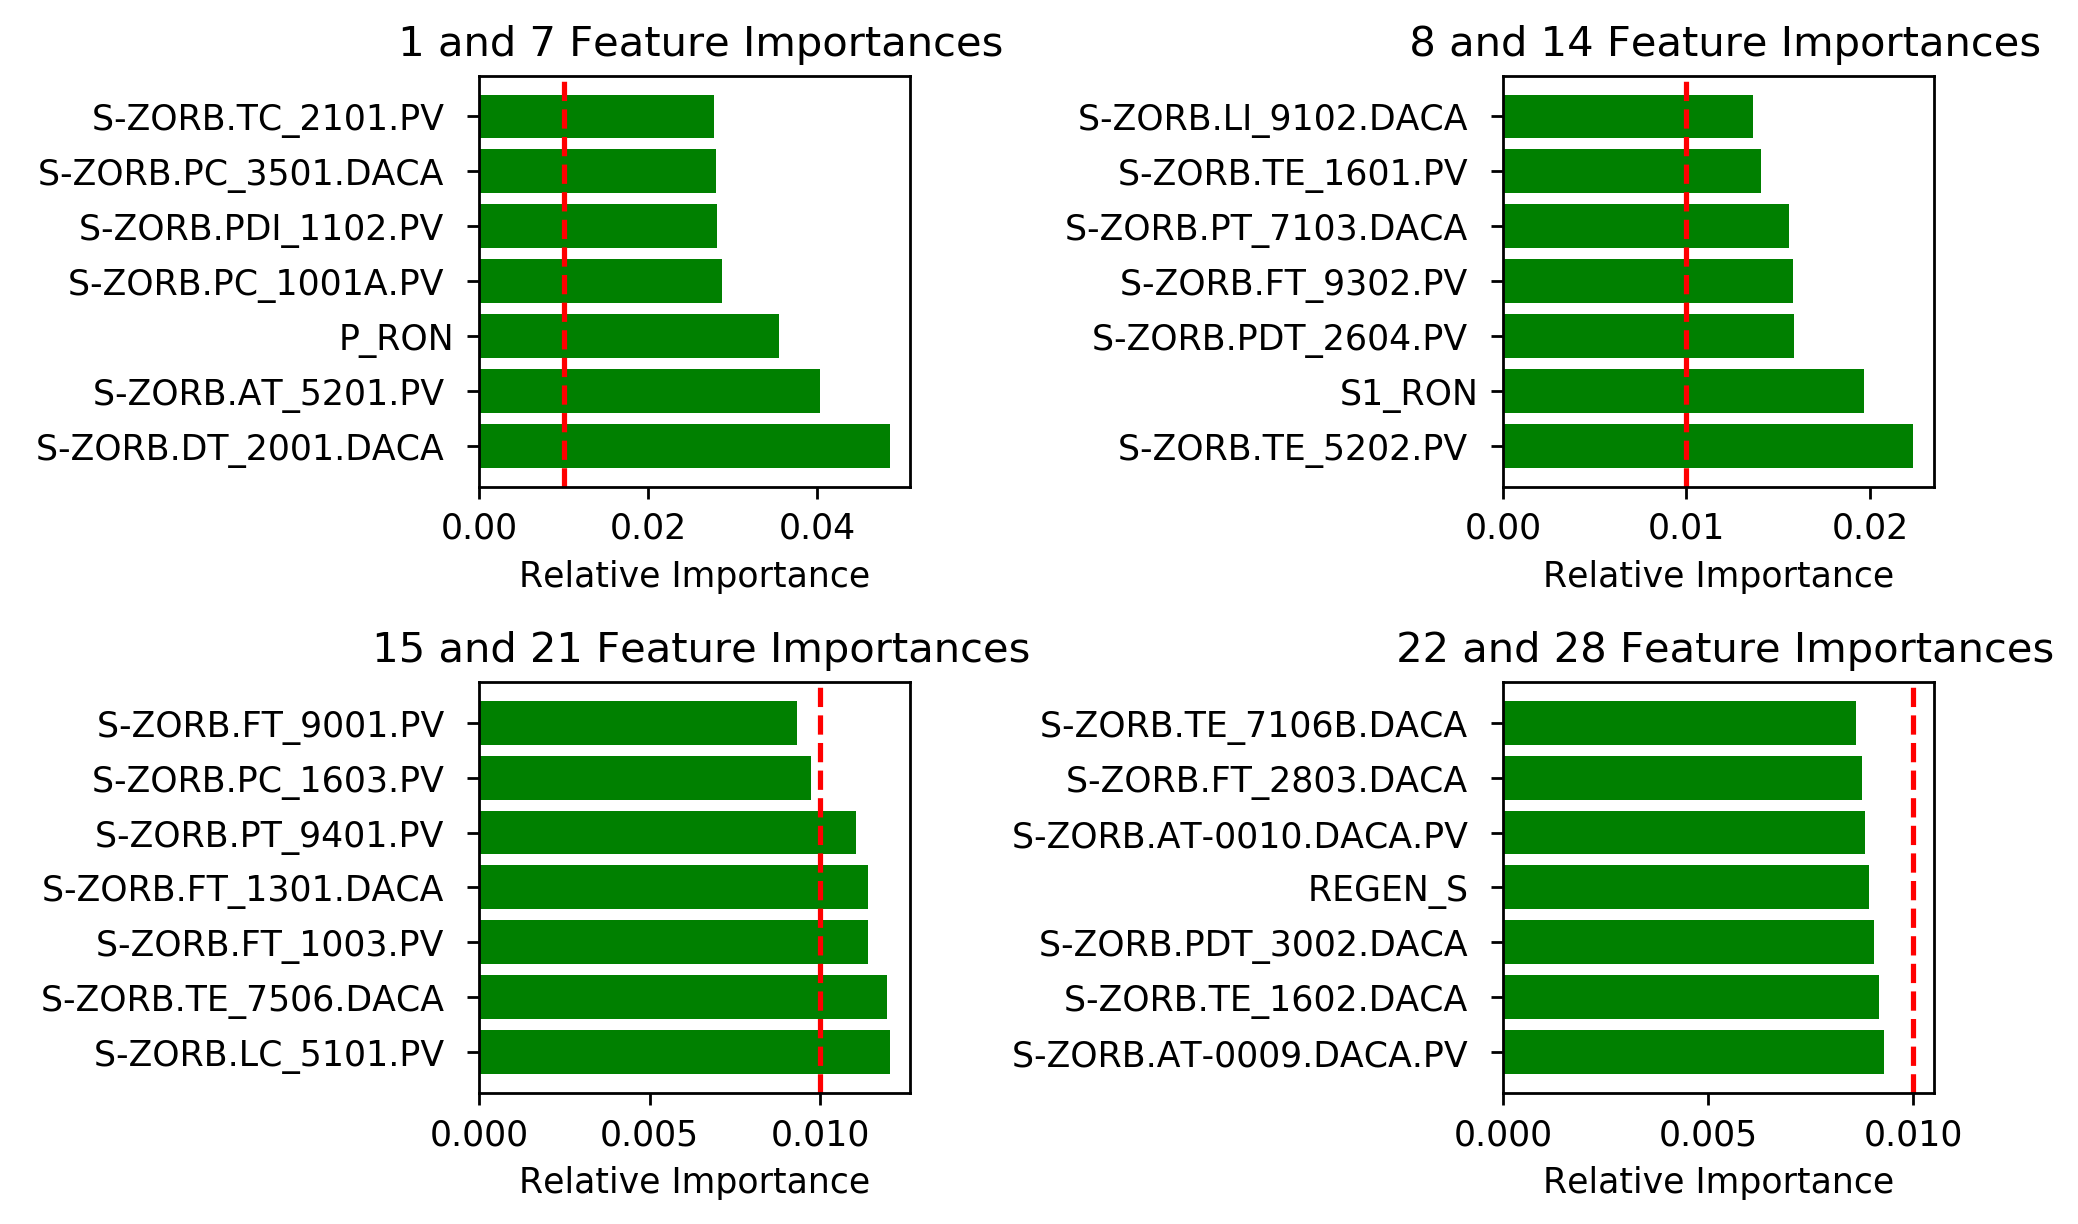

In [293]:
fig = plt.figure(figsize=[8,5] ,dpi = 250)   
e = [0 , 7 ,14 ,21]
for k , i in enumerate(e):
    indices = inde[i:i+7]
    plt.subplot(2,2,k+1)
    plt.title(' %d and %d Feature Importances' % (i+1 , i+7))
    plt.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.axvline(x=0.01,c="red", linestyle='--')#添加垂直虚线
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
fig.tight_layout()
plt.show()
#plt.savefig(r"C:\Users\Administrator\Desktop\Relative_Tmportance_367.jpg")

In [294]:
####用随机森林回归，判别系数重要性在0.01以上的操作变量有19个
a= importances[inde][0:19]
b = features[inde][0:19]

data_feature_19= pd.read_csv(r"C:\Users\Administrator\Desktop\table1_end_data.csv")

dd_x = data_feature_19.loc[:,b]
dd_y = data_feature_19.iloc[:,1]
dd = pd.concat([dd_y,dd_x] , axis = 1)
dd.to_csv(r"C:\Users\Administrator\Desktop\five.csv" , index = None)

In [307]:
b

Index([' S-ZORB.DT_2001.DACA ', ' S-ZORB.AT_5201.PV ', 'P_RON',
       ' S-ZORB.PC_1001A.PV ', ' S-ZORB.PDI_1102.PV ', ' S-ZORB.PC_3501.DACA ',
       ' S-ZORB.TC_2101.PV ', ' S-ZORB.TE_5202.PV ', 'S1_RON',
       ' S-ZORB.PDT_2604.PV ', ' S-ZORB.FT_9302.PV ', ' S-ZORB.PT_7103.DACA ',
       ' S-ZORB.TE_1601.PV ', ' S-ZORB.LI_9102.DACA ', ' S-ZORB.LC_5101.PV ',
       ' S-ZORB.TE_7506.DACA ', ' S-ZORB.FT_1003.PV ', ' S-ZORB.FT_1301.DACA ',
       ' S-ZORB.PT_9401.PV '],
      dtype='object')

In [308]:
x

,S1_S,S1_RON,S1_Alkane,S1_CnH2n,S1_C6H6,S1_Br,S1_density,P_S,P_RON,ADS_C,...,S-ZORB.CAL_1.CANGLIANG.PV,S-ZORB.FT_1006.DACA.PV,S-ZORB.FT_5204.DACA.PV,S-ZORB.FT_1006.TOTALIZERA.PV,S-ZORB.FT_5204.TOTALIZERA.PV,S-ZORB.FT_1503.DACA.PV,S-ZORB.FT_1503.TOTALIZERA.PV,S-ZORB.FT_1504.DACA.PV,S-ZORB.FT_1504.TOTALIZERA.PV,S-ZORB.PC_1001A.PV
0,188.0,90.6,53.23,24.40,22.37,61.49,726.09,3.2,89.22,2.32,...,2.0454,6368.7470,233.3108,83086802.00,832503.795,2.216409e+03,39063124.50,1840.1447,39608757.0,0.3533
1,169.0,90.5,52.30,26.40,21.30,61.88,731.30,3.2,89.32,2.37,...,2.0260,6360.6453,242.3692,82318954.00,803462.665,2.370587e+03,38810581.50,1641.7326,39389299.0,0.3545
2,177.0,90.7,52.30,26.31,21.39,61.72,729.61,3.2,89.32,2.43,...,1.9647,6504.9649,233.0769,82012004.00,791925.055,2.326465e+03,38693812.00,1600.6758,39312616.5,0.3502
3,159.0,90.4,52.30,26.10,21.60,61.33,725.40,3.2,89.02,3.08,...,2.0390,6506.8250,238.3499,81231373.50,762863.810,2.495224e+03,38410862.50,1563.7122,39120204.5,0.3539
4,173.0,89.6,52.24,26.67,21.09,61.33,725.43,3.2,88.32,2.45,...,1.9869,6560.2423,236.5762,80915707.50,751362.300,2.807789e+03,38283000.00,1554.3574,39045953.5,0.3581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,271.4,89.2,47.19,31.30,21.51,52.02,725.20,3.2,88.05,9.45,...,3.4546,8328.9748,150.4416,84087479.25,2136687.475,3.159956e+06,1569503.75,-7028.1167,1003276.5,-118.2512
321,271.4,89.2,47.19,31.30,21.51,52.02,725.20,3.2,87.95,9.09,...,2.7526,8457.8608,148.7484,83687113.25,2129270.425,3.662122e+06,1521263.75,-8555.3042,879436.8,-118.7643
322,271.4,89.4,47.19,31.30,21.51,52.02,725.20,3.2,88.05,5.72,...,2.9358,8246.2093,150.0954,83087625.75,2118469.700,4.415371e+06,1448903.75,-10846.0855,693676.8,-119.5341
323,266.0,89.4,46.72,33.78,19.50,45.45,730.00,3.6,88.12,4.33,...,3.1740,7998.8024,149.5340,82696129.75,2110959.450,4.917538e+06,1400663.75,-12373.2728,569836.8,-120.0473


In [309]:
y

,P_RON_LOSS
0,1.4
1,1.2
2,1.4
3,1.4
4,1.3
...,...
320,1.1
321,1.3
322,1.3
323,1.3
